<a href="https://colab.research.google.com/github/elenadigrigoli/FDS-project/blob/leb/RETENEURALE_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/elenadigrigoli/FDS-project.git

fatal: destination path 'FDS-project' already exists and is not an empty directory.


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Percorso del dataset
dataset_path = r'/content/FDS-project/data'

# Trasformazioni per preprocessing e data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale casuale
    transforms.RandomRotation(30),  # Rotazione casuale
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Modifica colori
    transforms.ToTensor(),  # Converte in tensore
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizza
])

# Caricamento del dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Divisione del dataset in train, validation e test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Creazione dei DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Controllo delle classi
print(f"Classi nel dataset: {full_dataset.classes}")


Classi nel dataset: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


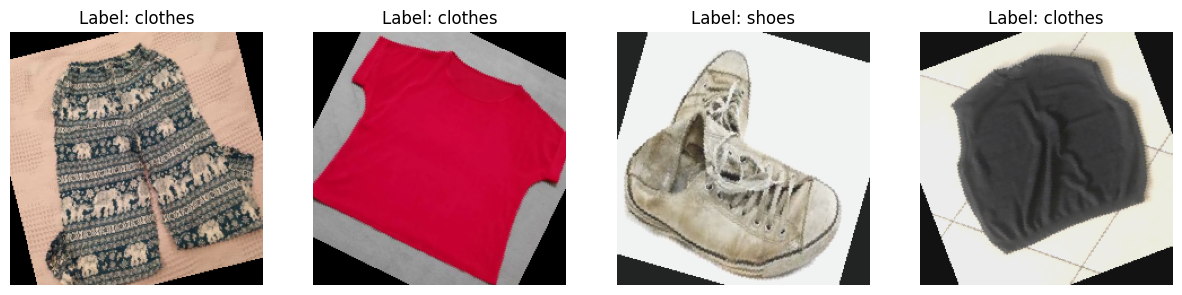

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per de-normalizzare le immagini
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()  # Crea una copia per evitare modifiche all'originale
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Operazione inversa della normalizzazione
    return tensor

# Funzione per visualizzare un batch di immagini
def show_images_from_loader(loader, full_dataset, mean, std):
    """
    Visualizza un batch di immagini preprocessate con le relative etichette.

    Args:
        loader (DataLoader): Il DataLoader da cui estrarre un batch.
        full_dataset (Dataset): Il dataset originale contenente le classi.
        mean (list): Media utilizzata per la normalizzazione.
        std (list): Deviazione standard utilizzata per la normalizzazione.
    """
    classes = full_dataset.classes  # Ottieni le classi dal dataset originale
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Preleva un batch

    # De-normalizza il batch
    images = images.clone()
    for i in range(images.size(0)):
        images[i] = denormalize_image(images[i], mean, std)

    # Converti in formato numpy per matplotlib
    images = images.numpy().transpose((0, 2, 3, 1))  # Da CxHxW a HxWxC

    # Visualizza le prime 4 immagini del batch
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(images):  # Evita errori se ci sono meno di 4 immagini nel batch
            break
        ax.imshow(np.clip(images[i], 0, 1))  # Assicura che i valori siano nel range [0, 1]
        ax.axis("off")
        ax.set_title(f"Label: {classes[labels[i]]}")
    plt.show()

# Parametri per la normalizzazione (standard ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Esegui la funzione per visualizzare un batch
show_images_from_loader(train_loader, full_dataset, mean, std)




In [10]:
import torch
import torch.nn as nn
from torchvision import models

# Verifica se la GPU è disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricamento del modello preaddestrato EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modifica del layer finale per 10 classi
num_classes = 10
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Sposta il modello su GPU (se disponibile)
model = model.to(device)


In [11]:
import torch.optim as optim

# Funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo di addestramento
num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    # Validazione
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_dataset):.4f}")


Epoch 1/8, Loss: 0.5313
Validation Loss: 0.2902, Accuracy: 0.9076
Epoch 2/8, Loss: 0.3044
Validation Loss: 0.2839, Accuracy: 0.9134
Epoch 3/8, Loss: 0.2546
Validation Loss: 0.2372, Accuracy: 0.9249
Epoch 4/8, Loss: 0.2102
Validation Loss: 0.2838, Accuracy: 0.9134
Epoch 5/8, Loss: 0.1945
Validation Loss: 0.2168, Accuracy: 0.9309
Epoch 6/8, Loss: 0.1715
Validation Loss: 0.2967, Accuracy: 0.9097
Epoch 7/8, Loss: 0.1557
Validation Loss: 0.1902, Accuracy: 0.9445
Epoch 8/8, Loss: 0.1356
Validation Loss: 0.1982, Accuracy: 0.9429


In [6]:
# Test del modello
model.eval()
test_loss, correct = 0.0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(1) == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {correct / len(test_dataset):.4f}")


Test Loss: 0.2590, Accuracy: 0.9185
